In [1]:
# Imports
import os
import sys
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from autosklearn.classification import AutoSklearnClassifier
p = os.path.abspath('..')
sys.path.insert(1, p)
from utils import add_to_autosklearn_pipeline
from notebook_utils import get_search_space_size

In [2]:
# Dataset
dataset = 'Cardiotocography'
data_iter = 1 # dataset iteration
# Import X_train, y_train, X_test, y_test
dataset_dir = '../data/processed/'+dataset+'/iter'+str(data_iter)+'/'
X_train = pd.read_csv(dataset_dir + 'X_train.csv')
y_train = pd.read_csv(dataset_dir + 'y_train.csv')
X_test = pd.read_csv(dataset_dir + 'X_test.csv')
y_test = pd.read_csv(dataset_dir + 'y_test.csv')

In [3]:
# PyOD classifiers
classifiers = [
    'CBLOFClassifier',
    'COPODClassifier',
    'IForestClassifier',
    'KNNClassifier',
    'LOFClassifier',
]
# Add classifiers to AutoSklearn pipeline
add_to_autosklearn_pipeline(classifiers)
# Create the search space
for clf in classifiers:
    print('{}: {}'.format(clf, get_search_space_size([clf])))
# Size of the total hyperparameter space
total_search_space = get_search_space_size(classifiers)
print('Total space size:', total_search_space)

CBLOFClassifier: 9500000
COPODClassifier: 50
IForestClassifier: 164791900
KNNClassifier: 60000
LOFClassifier: 20000
Total space size: 174371950


In [4]:
# Budget estimation parameters
times = []
per_run_budget = 30
n_total = 100 # attempted runs
n_succeeded = 0 # succeeded runs
n_failed = 0 # failed runs
# Loop over total attempts
for i in tqdm(range(n_total)):
    # Sample a model
    idx = random.randint(0, len(classifiers)-1) # index
    model = classifiers[idx]
    # Create AutoSklearn classifier
    cls = AutoSklearnClassifier(
        time_left_for_this_task=per_run_budget,
        per_run_time_limit=per_run_budget,
        include={
            'classifier': [model]
        },
        delete_tmp_folder_after_terminate=False,
    )
    # Sample a configuration 
    cs = cls.get_configuration_space(X_train, y_train)
    config = cs.sample_configuration()
    # Fit the model[configuration]
    _, _, run_value = cls.fit_pipeline(
        X=X_train,
        y=y_train,
        config=config,
        X_test=X_test,
        y_test=y_test,
    )
    # Check success and store time
    if 'SUCCESS' in str(run_value[2]):
        times.append(run_value[1])
        n_succeeded += 1
    else:
        n_failed += 1
# Report successful vs failed runs
print('Runs attempted:\t\t\t', n_total)
print('Runs succeeded:\t\t\t', n_succeeded)
print('Runs failed:\t\t\t', n_failed)
print('Total time passed:\t\t', int(np.sum(times)))

100%|██████████| 100/100 [15:32<00:00,  9.33s/it]

Runs attempted:			 100
Runs succeeded:			 87
Runs failed:			 13
Total time passed:		 234


In [6]:
# Results
avg_time = round(np.average(times), 2)
std_time = round(np.std(times), 2)
conf_percentage = 0.01 # percentage of configurations to try
n_confs = int(total_search_space * conf_percentage) # configurations needed to run
alpha = 2 # 95% confidence
n_confs_budget = int(n_confs * (avg_time + alpha * std_time)) 
# Print statistics
print('Average run time per fit:\t\t\t', avg_time)
print('Standard deviation of the distribution:\t\t', std_time)
print('Budget for {}% of configurations ({}):\t {}'.format(conf_percentage*100, n_confs, n_confs_budget))

Average run time per fit:			 2.7
Standard deviation of the distribution:		 2.78
Budget for 1.0% of configurations (1743719):	 14403118


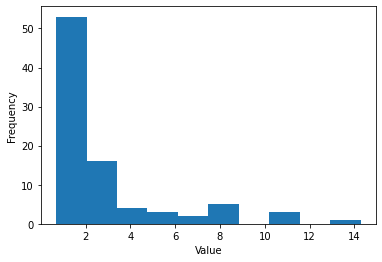

Shapiro-Wilk test results:
 ShapiroResult(statistic=0.6996697783470154, pvalue=4.7646582859717235e-12)


In [19]:
# Distribution plot
from matplotlib import pyplot as plt
plt.hist(times, bins=10)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.savefig('t_hist.png')
plt.show()
# Shapiro-Wilk test for normality
from scipy import stats
shapiro_test = stats.shapiro(times)
print('Shapiro-Wilk test results:\n', shapiro_test)